# Analysis of matched RX and TX rates across valid ranges

This notebook analyzes the link status of samples rates from 100 MHz to 500 MHz, where both the TX and RX rates at the framers are the same. This is primarily looking for issues and/or patherns with the clocking configurations to determine if there are issues with JIF or another component in the system.

To scale the sample rate from 100 MHz to 500 MHz, decimators, interpolators, ADC rate, and DAC rate are automatically determine to be within valid ranges.

Details of the system:
- Hardware: AD9081 + ZCU102
- Linux master branch from 3/23/2022
- HDL master branch from 3/23/2022
- VCXO 122.88 MHz
- TX JESD Mode 9, RX JESD Mode 10.00

In [1]:
import json
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
#!pip install pyqt5
%matplotlib inline

## Import and filter data to extract desired log fields

In [2]:
files = glob.glob("../logs/*.json")

results = []
for file in files:
    with open(file) as f:
        data_ref = json.load(f)
        data = {}
        if 'cfg' not in data_ref:
            continue
        data['status'] = data_ref['status']
        data['rx_lane_rate'] = data_ref['cfg']['jesd_adc']['bit_clock']
        data['tx_lane_rate'] = data_ref['cfg']['jesd_dac']['bit_clock']
        data['rx_sample_rate'] = data_ref['cfg']['jesd_adc']['sample_clock']
        data['tx_sample_rate'] = data_ref['cfg']['jesd_dac']['sample_clock']
        data['DAC_freq'] = data_ref['param_set']['DAC_freq']
        for k in data_ref['param_set']:
            data[k] = data_ref['param_set'][k]

        # Merge clock dividers
        od = data_ref['cfg']['clock']['out_dividers']
        od.sort()
        ods = ''
        for i, k in enumerate(od):
            ods += f" / {k}"

        data[f"out_dividers"] = ods[2:]
            
        if 'jdevices_statuses' in data_ref:
            ks = list(data_ref['jdevices_statuses'].keys())
            data[ks[0]] = data_ref['jdevices_statuses'][ks[0]]['enabled']
            data[ks[1]] = data_ref['jdevices_statuses'][ks[1]]['enabled']
    results.append(data)

df = pd.DataFrame(results, columns=results[0].keys())
df.sort_values(by=['status'])

,status,rx_lane_rate,tx_lane_rate,rx_sample_rate,tx_sample_rate,DAC_freq,ADC_freq,fddc,cddc,fduc,cduc,out_dividers,84a90000.axi-jesd204-rx,84b90000.axi-jesd204-tx
154,failed,9.640000e+09,9.640000e+09,241000000,241000000,3856000000,1928000000,4,2,8,2,10 / 12 / 12 / 384 / 384,disabled,disabled
134,failed,4.560000e+09,4.560000e+09,114000000,114000000,3648000000,1824000000,8,2,8,4,24 / 24 / 30 / 768 / 768,disabled,disabled
136,failed,8.560000e+09,8.560000e+09,214000000,214000000,3424000000,1712000000,4,2,8,2,12 / 12 / 30 / 384 / 384,disabled,disabled
137,failed,1.528000e+10,1.528000e+10,382000000,382000000,6112000000,3056000000,4,2,8,2,5 / 8 / 8 / 256 / 256,disabled,disabled
247,failed,1.412000e+10,1.412000e+10,353000000,353000000,5648000000,2824000000,4,2,8,2,5 / 8 / 8 / 256 / 256,disabled,disabled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,passed,5.480000e+09,5.480000e+09,137000000,137000000,3288000000,1644000000,6,2,6,4,18 / 18 / 30 / 576 / 576,enabled,enabled
139,passed,1.012000e+10,1.012000e+10,253000000,253000000,4048000000,2024000000,4,2,8,2,12 / 12 / 30 / 384 / 3456,enabled,enabled
140,passed,7.960000e+09,7.960000e+09,199000000,199000000,3184000000,1592000000,4,2,8,2,5 / 16 / 16 / 512 / 512,enabled,enabled
109,passed,7.320000e+09,7.320000e+09,183000000,183000000,2928000000,1464000000,4,2,8,2,5 / 16 / 16 / 512 / 512,enabled,enabled


## Plots of Link Enabled Pass/Fail at Boot

In [3]:
# Plot pass/fail over frequency
results = df[['status','rx_sample_rate','ADC_freq','DAC_freq']]

pc = pd.DataFrame(['passed']*len(results['status']),columns=['passed'])
choices = [1,0]
conditions = [results['status'] == pc['passed'],results['status'] != pc['passed']]

out = list(np.select(conditions, choices))
results = results.assign(passed = out);
results.sort_values(by=['rx_sample_rate'], inplace=True)

[Text(0, 0, 'Failed'), Text(0, 1, 'Passed')]

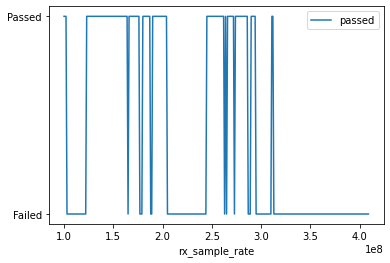

In [4]:
ax = results.plot(x='rx_sample_rate', y='passed')
ax.set_yticks([0,1])
ax.set_yticklabels(("Failed","Passed"))

[Text(0, 0, 'Failed'), Text(0, 1, 'Passed')]

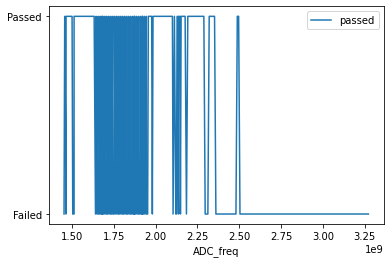

In [5]:
results.sort_values(by=['ADC_freq'], inplace=True)
ax = results.plot(x='ADC_freq', y='passed')
ax.set_yticks([0,1])
ax.set_yticklabels(("Failed","Passed"))

[Text(0, 0, 'Failed'), Text(0, 1, 'Passed')]

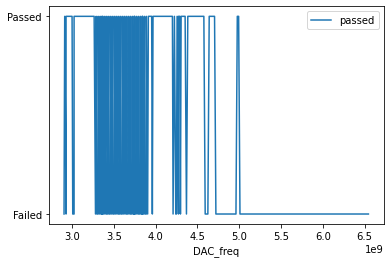

In [6]:
results.sort_values(by=['DAC_freq'], inplace=True)
ax = results.plot(x='DAC_freq', y='passed')
ax.set_yticks([0,1])
ax.set_yticklabels(("Failed","Passed"))

In [7]:
# Look at stacked trends

# target = "ADC_freq"
# df2 = df.groupby([target,'status'])['status'].count().unstack().fillna(0)
# df2
# df2.plot(kind='bar', stacked=True)